<font size=25>Laboratory 4 summary</font>

In this lab you will gain debugging experience by solving the most typical deep learning bugs.

There are 13 exercises, each one with a corresponding cell. Run the cell, inspect the error and fix the code.

Tips:
 - the bugs can be fixed in several lines of code (usually one or two)
 - some code in the sections must not be modified and is clearly delimited with comments
 - try not to inspect other exercises while solving the current one

# **Bugs everywhere**

In [ ]:
from __future__ import print_function, division
import os
import torch
import random
from typing import Iterator, List, Callable, Tuple
from functools import partial
import warnings
from math import *
import zipfile
from tqdm import tqdm
from PIL import Image

# Sklearn
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
# Numpy
import numpy as np
# Pandas
import pandas as pd

# PyTorch packages
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn as nn
import torch.optim as optim

# matplotlib
from matplotlib import rc, cm
rc('animation', html='jshtml')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
%matplotlib notebook
#warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

## Exercise 1: Getting started


In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 2)
        self.activation_fn = activation_fn

    def forward(self, x):
        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY MODEL INSTANTIATION
model = MLP(input_size=100, hidden_size=256, activation_fn=nn.ReLU())

# issue: wrong input shape
#x = torch.rand(32, 200)

# solution
x = torch.rand(32, 100)

y = model(x)
assert y.shape[0] == 32 and y.shape[1] == 2, "Wrong output shape"

## Exercise 2: Getting in shape

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        # self.output_layer = nn.Linear(2*hidden_size, 2)
        # issue 1: output_layer input size doesn't match hidden_layer output
        # size => modify self.output_layer dimensions
        self.output_layer = nn.Linear(hidden_size, 2)
        self.activation_fn = activation_fn

    def forward(self, x):
        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY MODEL INSTANTIATION
model = MLP(input_size=784, hidden_size=256, activation_fn=nn.ReLU())

# download MNIST dataset
mnist_trainset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())

# select 10th example
x, l = mnist_trainset[10]

# issue 2: shape of x is 1x3x32x32, but the network takes a tensor of shape 784
# solution: resize x before feeding it to the network
# when -1 is passed as an argument, the actual dimension is inferred from the
# remaining dimensions
# 1x3x32x32 -> 1x(784)
x = x.view(1, -1)
y = model(x)
assert y.shape[0] == 1 and y.shape[1] == 2, "Wrong output shape"

In [ ]:
mnist_trainset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())


In [ ]:
mnist_trainset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

## Exercise 3: It's the little things

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 2)
        self.activation_fn = activation_fn

    def forward(self, x):
        h = self.hidden_layer(x)

        # issue 1: activation_fn is accidentally applied over x
        # instead of h => shape mismatch
        # h = self.activation_fn(x)

        # solution:
        h = self.activation_fn(h)

        out = self.output_layer(h)

        return out

# issue 2: activation_fn is accidentally passed as a function pointer,
# instead of object
# model = MLP(input_size=784, hidden_size=256, activation_fn=nn.ReLU)

# solution:
model = MLP(input_size=784, hidden_size=256, activation_fn=nn.ReLU())

x = torch.rand(32, 784)
y = model(x)
assert y.shape[0] == 32 and y.shape[1] == 2, "Wrong output shape"

## Exercise 4: No one left behind

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 batch_size: int,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.batch_size = batch_size
        self.activation_fn = activation_fn

    def forward(self, x):
        # issue: for batch_size=32, we always expected tensors of size
        # 32 x 1 x 28 x 28. However, the last batch in the dataset was 16,
        # so the view function below reshaped the 16 x 1 x 28 x 28 tensor to
        # 32 x (1 x 14 x 14) = 32 x 784. This new dimension (784) turned out
        # to be incompatible with the first layer of the network

        # input x has shape: batch_size x 1 x 28 x 28
        # we resize it to:   batch_size x 784
        # x = x.view(self.batch_size, -1)

        # solution 2:
        # We extract the actual batch size first and then resize the tensor
        # accordingly.
        current_batch_size = x.shape[0]
        x = x.view(current_batch_size, -1)

        # solution 3:
        # We resize the tensor based on the 1st input layer dimension
        x = x.view(-1, 784)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# instantiate model
BATCH_SIZE=32
model = MLP(
    input_size=784,
    hidden_size=256,
    activation_fn=nn.ReLU(),
    batch_size=BATCH_SIZE
)

# instantiate MNIST dataset
val_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor())
print("validation dataset size = ", len(val_dataset))

# issue: dataset has 10000 examples, so the last batch has only 16 elements
# instead of 32. The forward method in the MLP class has a bug.
# It accidentally reshapes the last batch Tensor from 16 x 1 x 28 x 28
# to 32 x (1 x 14 x 14) = 32 x 196. Therefore, the new tensor shape is
# incompatible with the first layer of the model.
# val_dataloader = DataLoader(
#     val_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True
# )

# solution 1: set the drop_last argument in the DataLoader to True. This
# drops the last batch (which may have a different shape) so that all
# the batches have the same number of examples
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in val_dataloader:
    # batch_size x 2
    out = model(batch_images)
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

epoch_loss /= len(val_dataloader)
print("Validation loss = ", epoch_loss)

validation dataset size =  10000
Validation loss =  2.3085830303045887


## Exercise 5: Left to their own devices


In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 batch_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.device = device
        self.batch_size = batch_size

    def forward(self, x):
        # issue: Tensor.to() is not an in-place operation, so tensor x
        # remains on CPU
        # -
        # move input data to GPU (if available)
        # x.to(self.device)

        # solution
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        x = x.view(self.batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

# DO NOT MODIFY DEVICE TENSOR BELOW
###################################################################################
BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device = ", device)
###################################################################################

# instantiate model
model = MLP(
    input_size=784, hidden_size=256, activation_fn=nn.ReLU(), batch_size=32,
    device=device
)

# move model to GPU (Module.to() is an in-place operation, it recursively
# processes parameters inside your nn.Module)
model.to(device)

# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    # issue: Tensor.to() is not an in-place operation (though Model.to() is)
    # therefore batch_labels remains on CPU
    # -
    # move labels to GPU (if available)
    # batch_labels.to(device)

    # solution:
    #batch_labels=batch_labels.to(device)

    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

device =  cuda
train dataset size =  60000


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)

## Exercise 6: Not exactly my type

### Task I

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 batch_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.device = device
        self.batch_size = batch_size

    def forward(self, x):
        # reshape tensor
        # batch_size x 784
        x = x.view(self.batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# instantiate model
model = MLP(
    input_size=784, hidden_size=256, activation_fn=nn.ReLU(), batch_size=32,
    device=device
)

# issue: the dataset was downloaded but the input was not converted to Tensors,
# which leads to a type mismatch during feedforward
# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    print(batch_labels)

    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

### Task II

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 64
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=64, hidden_size=256, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# load the 1797 images from the Digits dataset:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html
# Images are grayscale digits from 0 to 9, stored as arrays of size 64 (8x8).
# Both images and labels are stored are NumPy arrays, so we need to convert
# them to Tensors.
x = load_digits()

# issue: NumPy arrays are 64bit floating point type, so torch.tensor() converts
# them to Tensors of type Double (torch.float64) by default. However,
# the default type of Tensors is torch.float32, so when we instantiated the
# model, its parameters have type torch.float32 as well. This leads to a
# type mismatch when feeding a torch.float64 input to the first layer.
# -
# 1797 x 64, 1797
#images, labels = torch.tensor(x.data), torch.tensor(x.target)

# solution 1: specify dtype argument in the torch.tensor() constructor
images, labels = torch.tensor(x.data, dtype=torch.float32), torch.tensor(x.target)

# solution 2: use torch.to(dtype=torch.float32) to convert to Float type
images, labels = torch.tensor(x.data), torch.tensor(x.target)
images = images.to(dtype=torch.float32)

# solution 3: call .float() on tensor to convert it to Float type
images, labels = torch.tensor(x.data), torch.tensor(x.target)
images = images.float()

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (1797 in our case)
train_dataset = TensorDataset(images, labels)

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in train_dataloader:
    batch_labels=batch_labels.to(device)

    # batch_size x 2
    # feedforward
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

## Exercise 7: Out of bounds
The [Wheat Seeds](https://archive.ics.uci.edu/ml/datasets/seeds) dataset ([Kaggle link](https://www.kaggle.com/jmcaro/wheat-seedsuci)) is a classification task with 3 classes, which contains 209 examples. Each example contains 7 geometrical properties of wheat seeds belonging to 3 varieties of wheat.

**Hint 1:** When training on GPUs, CUDA errors may be less helpful. Usually, errors such as "`RuntimeError: CUDA error: device-side assert triggered`" indicate a problem with an index, which may be too large. To get a more accurate error message, move the model and dataset to CPU, check the error again and try to fix it.

**Hint 2:** After fixing the code responsible for a CUDA error, you may still encounter the error when running on GPU. Try restarting the Colab Notebook (`Runtime` -> `Restart runtime`) and run the cells again.


In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# issue: the labels read from the CSV are 1, 2 and 3. However, the scores that
# the model outputs in the `out` tensor are indexed from 0 to 2, leading to
# an index error when trying to access out[:, 3]
#x = torch.tensor(data.values, dtype=torch.float32)
#data, labels = x[:,:-1], x[:,-1].long()

# solution: subtract 1 from the `labels` tensor
x = torch.tensor(data.values, dtype=torch.float32)
data, labels = x[:,:-1], x[:,-1].long()-1

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)
validation_dataset = TensorDataset(data, labels)

# instantiate dataloader
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
for batch_images, batch_labels in validation_dataloader:
    batch_labels=batch_labels.to(device)

    # feedforward
    # batch_size x 3
    out = model(batch_images)

    # compute loss
    loss = loss_crt(out, batch_labels)
    epoch_loss += loss.item()

epoch_loss /= len(validation_dataloader)
print("Validation loss = ", epoch_loss)

device =  cpu
--2024-03-19 10:31:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0s      

2024-03-19 10:31:16 (76.4 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

Validation loss =  1.7850461517061507


In [ ]:
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Exercise 8: I have no memory of that

**Hint 1:** The error will appear after ~1 epoch

**Hint 2:** You do NOT need to modify the model's size to fix the memory bug

**Hint 3:** After getting the error message, you have to restart the machine:
  - restart Colab: `Runtime` -> `Restart runtime`
  - run the cell that imports packages
  - run the cell below

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size_1: int,
                 hidden_size_2: int,
                 hidden_size_3: int,
                 hidden_size_4: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_layer_1 = nn.Linear(input_size, hidden_size_1)
        self.hidden_layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.hidden_layer_3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.hidden_layer_4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.output_layer = nn.Linear(hidden_size_4, 10)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        x = x.view(-1, self.input_size)

        h1 = self.activation_fn(self.hidden_layer_1(x))
        h2 = self.activation_fn(self.hidden_layer_2(h1))
        h3 = self.activation_fn(self.hidden_layer_3(h2))
        h4 = self.activation_fn(self.hidden_layer_4(h3))
        out = self.output_layer(h4)

        return out

BATCH_SIZE=32
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device = ", device)

# DO NOT MODIFY MODEL INSTANTIATION BELOW
#########################################
model = MLP(
    input_size=784,
    hidden_size_1=16384,
    hidden_size_2=16384,
    hidden_size_3=16384,
    hidden_size_4=16384,
    activation_fn=nn.ReLU(),
    device=device
)
#########################################

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# instantiate MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor())
print("train dataset size = ", len(train_dataset))

# instantiate dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

loss_crt = nn.CrossEntropyLoss()
epoch_loss = 0.0
num_batches = len(train_dataloader)
for epoch in range(20):
    for idx, (batch_images, batch_labels) in enumerate(train_dataloader):
        if idx % 50 == 0:
            print("epoch %d, batch %d/%d" % (epoch, idx, num_batches))

        # move labels to GPU (if available)
        batch_labels=batch_labels.to(device)

        # batch_size x 2
        # feedforward
        out = model(batch_images)

        # compute loss
        loss = loss_crt(out, batch_labels)

        # issue:
        # loss is a Tensor, which contains the whole computational graph
        # of the model. When adding it to the epoch_loss counter, the
        # computational graph of each training loop is accumulated in the
        # epoch_loss variable, instead of being discarded. Thus, the memory
        # usage continues to increase until the out of memory error appears.
        # you can also see this issue discussed here:
        # https://pytorch.org/docs/stable/notes/faq.html#my-model-reports-cuda-runtime-error-2-out-of-memory
        # -
        # epoch_loss += loss

        # solution:
        # extract the scalar from the loss Tensor with .item()
        # since the loss variable is not further used, the memory required
        # for the computational graph is freed after every iteration
        epoch_loss += loss.item()

    epoch_loss /= num_batches
    print("epoch loss = ", epoch_loss)

## Exercise 9: Underground

Validation accuracy on CIFAR10 with this simple MLP should reach ~48%. However, there is a bug preventing that from happening.

**Hint**: Inspect the training and validation losses.

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 output_activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.output_activation_fn = output_activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)
        out = self.output_activation_fn(out)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

# issue 1: NLLLoss (negative log-likelihood loss) in PyTorch assumes that
# log probabilities have already been computed. See documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html?highlight=nllloss#torch.nn.NLLLoss)
# Therefore, network outputs should pass through a logSoftMax() activation
# function instead of a SoftMax. This is why SoftMax + NLLLoss actually
# leads to negative loss values below.
#
# issue 2: The softmax is computer over dimension 0 (batch dimension) instead
# of over dimension 1 (classes). This leads to further performance decrease
# model = MLP(
#     input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
#     output_activation_fn=nn.Softmax(dim=0)
# )
model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    output_activation_fn=nn.LogSoftmax(dim=1)
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.NLLLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_epoch_loss,
        val_epoch_loss,
        train_acc,
        val_acc
    ))


device =  cuda
Files already downloaded and verified
Files already downloaded and verified
train dataset size =  50000
validation dataset size =  10000
epoch 0, train loss=-0.038127, val loss=-0.045962, train acc=0.286600, val acc=0.312400


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 1, train loss=-0.046387, val loss=-0.048600, train acc=0.295360, val acc=0.310750


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 2, train loss=-0.047992, val loss=-0.049806, train acc=0.302033, val acc=0.314367


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 3, train loss=-0.049848, val loss=-0.051421, train acc=0.307030, val acc=0.315700


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 4, train loss=-0.050707, val loss=-0.051735, train acc=0.309152, val acc=0.318280


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 5, train loss=-0.052211, val loss=-0.050678, train acc=0.312237, val acc=0.319050


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 6, train loss=-0.052506, val loss=-0.053132, train acc=0.314620, val acc=0.319829


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 7, train loss=-0.054328, val loss=-0.054080, train acc=0.316395, val acc=0.320987


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 8, train loss=-0.054913, val loss=-0.054100, train acc=0.318173, val acc=0.322678


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 9, train loss=-0.055258, val loss=-0.052426, train acc=0.319640, val acc=0.323640


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 10, train loss=-0.055959, val loss=-0.054045, train acc=0.320678, val acc=0.325218


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 11, train loss=-0.056480, val loss=-0.054858, train acc=0.321898, val acc=0.326025


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 12, train loss=-0.056668, val loss=-0.053678, train acc=0.323018, val acc=0.326515


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 13, train loss=-0.057034, val loss=-0.055286, train acc=0.324170, val acc=0.326929


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 14, train loss=-0.057877, val loss=-0.057245, train acc=0.325089, val acc=0.327700


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 15, train loss=-0.058304, val loss=-0.057257, train acc=0.326185, val acc=0.328569


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 16, train loss=-0.059129, val loss=-0.055533, train acc=0.327141, val acc=0.329865


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 17, train loss=-0.059517, val loss=-0.055422, train acc=0.327928, val acc=0.330394


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 18, train loss=-0.058904, val loss=-0.055866, train acc=0.328846, val acc=0.330768


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch 19, train loss=-0.059345, val loss=-0.056032, train acc=0.329380, val acc=0.331735


In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 10: Validation >> Train

Train the network and inspect the train and validation accuracy curves. Notice a large gap in accuracy (>5%) throughout the epochs. You have adjust the code below such that:
 - the accuracy gap between train and validation becomes smaller
 - validation performance gets better

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 dropout_rate: float):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_rate)
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.activation_fn(self.dropout(self.hidden_layer(x)))
        out = self.output_layer(h)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

# issue: dropout rate was set too high, affecting the learning performance on
# the training set. The validation performance was higher than training, due to
# dropout being disabled during evaluation
# model = MLP(
#     input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
#     dropout_rate=0.9
# )

# solution: set smaller dropout rate
model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    dropout_rate=0.2
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.CrossEntropyLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_acc,
        val_acc
    ))


In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exercise 11: Blown out of proportions

In [ ]:
class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable,
                 output_activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 10)
        self.activation_fn = activation_fn
        self.output_activation_fn = output_activation_fn
        self.device = device

    def forward(self, x):
        # move input data to GPU (if available)
        x = x.to(self.device)

        # reshape tensor
        # batch_size x 784
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)
        out = self.output_activation_fn(out)

        return out

BATCH_SIZE=128
NUM_EPOCHS=20
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print("device = ", device)

model = MLP(
    input_size=3072, hidden_size=1024, activation_fn=nn.ReLU(), device=device,
    output_activation_fn=nn.Softmax(dim=0)
)
model.to(device)

# instantiate MNIST train and validation datasets
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print("train dataset size = ", len(train_dataset))
print("validation dataset size = ", len(val_dataset))

# instantiate dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4
)
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

avg_grad_norms = []

# DO NOT MODIFY LOSS FUNCTION BELOW
##############################################################################
loss_crt = nn.CrossEntropyLoss()
##############################################################################

optimizer = optim.Adam(model.parameters(), lr=3e-4)
for epoch_idx in range(NUM_EPOCHS):
    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        # batch_size x 10
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)
        train_predictions += batch_predictions.tolist()
        train_labels += batch_labels.tolist()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()

        for name, param in model.named_parameters():
            epoch_grad_norms = []
            if param.grad is not None:
                epoch_grad_norms.append(torch.norm(param.grad).cpu().numpy())
            avg_grad_norms.append((sum(epoch_grad_norms) / len(epoch_grad_norms)))


        optimizer.step()
        train_epoch_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)
            val_predictions += batch_predictions.tolist()
            val_labels += batch_labels.tolist()

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)

    train_acc = accuracy_score(train_labels, train_predictions)
    val_acc = accuracy_score(val_labels, val_predictions)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print("epoch %d, train acc=%f, val acc=%f" % (
        epoch_idx,
        train_acc,
        val_acc
    ))

device =  cuda


100%|██████████| 170M/170M [00:06<00:00, 25.8MB/s]


train dataset size =  50000
validation dataset size =  10000


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 0, train acc=0.270780, val acc=0.297100


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 1, train acc=0.287890, val acc=0.303500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 2, train acc=0.295500, val acc=0.308633


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 3, train acc=0.301440, val acc=0.314025


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 4, train acc=0.305912, val acc=0.316500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 5, train acc=0.309407, val acc=0.317483


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 6, train acc=0.312114, val acc=0.318529


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 7, train acc=0.314555, val acc=0.319525


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 8, train acc=0.316673, val acc=0.321478


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 9, train acc=0.318628, val acc=0.323570


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 10, train acc=0.320333, val acc=0.325009


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 11, train acc=0.322158, val acc=0.326333


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 12, train acc=0.323863, val acc=0.327508


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 13, train acc=0.325190, val acc=0.328557


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 14, train acc=0.326364, val acc=0.329660


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 15, train acc=0.327759, val acc=0.331087


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 16, train acc=0.329180, val acc=0.332200


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 17, train acc=0.330547, val acc=0.333128


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 18, train acc=0.331716, val acc=0.334011


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch 19, train acc=0.332890, val acc=0.334835


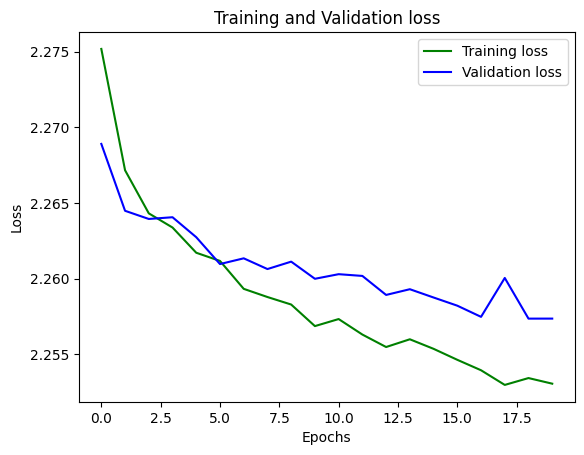

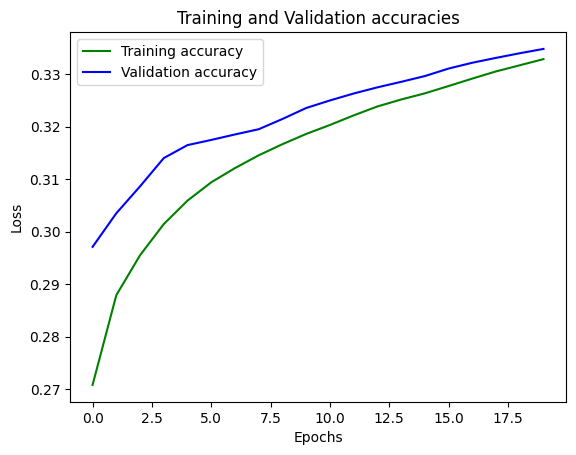

<ipython-input-3-e46d9ef433d6>:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


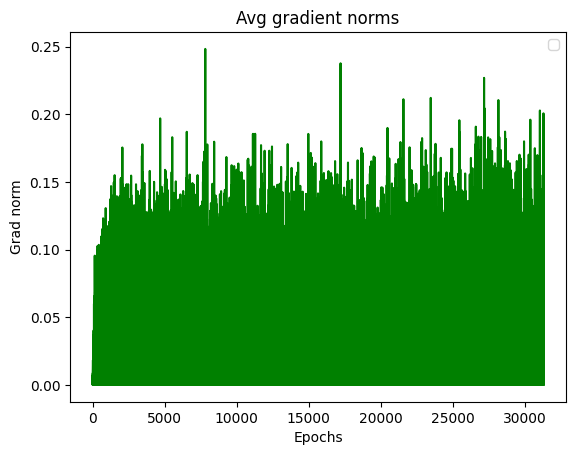

In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(0,len(avg_grad_norms)), avg_grad_norms, 'g')
plt.title('Avg gradient norms')
plt.xlabel('Epochs')
plt.ylabel('Grad norm')
plt.legend()
plt.show()

## Exercise 12: Let's set things in order...


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# solution: subtract 1 from the `labels` tensor
x = torch.tensor(data.values, dtype=torch.float32)
data, labels = x[:,:-1], x[:,-1].long()-1

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)

train_percent = 0.75
num_samples = len(data)
train_indices = range(0, int(num_samples * train_percent))
valid_indices = range(int(num_samples * train_percent), len(data))

# issue: we don't shuffle the dataset, we don't have balanced number of samples
# from random import shuffle
# indices = list(range(num_samples))
# shuffle(indices)
# train_indices = indices[:int(num_samples * train_percent)]
# valid_indices = indices[int(num_samples * train_percent):]

training_dataset = TensorDataset(data[train_indices], labels[train_indices])
validation_dataset = TensorDataset(data[valid_indices], labels[valid_indices])

# instantiate train dataloader
train_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    #shuffle=True
)

# instantiate validation dataloader
val_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

loss_crt = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=3e-4)
NUM_EPOCHS = 100

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()
            val_labels += batch_labels.tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

device =  cpu
--2024-03-19 13:39:45--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0s      

2024-03-19 13:39:45 (62.4 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

epoch 0, train loss=2.969939, val loss=0.262856, train acc=0.108974, val acc=1.000000
epoch 1, train loss=2.249720, val loss=0.484611, train acc=0.108974, val acc=1.000000
epoch 2, train loss=1.694438, val loss=0.800924, train acc=0.108974, val acc=1.000000
epoch 3, train loss=1.324144, val loss=1.169048, train acc=0.006410, val acc=0.000000
epoch 4, train loss=1.124870, val loss=1.520979, train a

## Exercise 13: Weighing the evidence



In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class MLP(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: int,
                 device: torch.device,
                 activation_fn: Callable):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 3)
        self.activation_fn = activation_fn
        self.device = device

    def forward(self, x):
        # batch_size x 7
        x = x.to(self.device)

        h = self.hidden_layer(x)
        h = self.activation_fn(h)
        out = self.output_layer(h)

        return out

BATCH_SIZE=32

# if you encounter a vague CUDA error message, move the operations to CPU then
# run the code again. The error message is usually more helpful.
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

# instantiate model
model = MLP(
    input_size=7, hidden_size=128, activation_fn=nn.ReLU(), device=device
)

# move model to GPU (Module.to() is an in-place operation)
model.to(device)

# download Wheat Seeds dataset
!wget --no-check-certificate \
https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv \
-O /tmp/wheat.csv

# read Wheat Seeds dataset from csv
# Dataset has 209 examples. Each example has 7 attributes (features).
# It's a classification task with 3 classes (1, 2 and 3)
data = pd.read_csv("/tmp/wheat.csv")

# solution: subtract 1 from the `labels` tensor
x = torch.tensor(data.values, dtype=torch.float32)
data, labels = x[:,:-1], x[:,-1].long()-1

# we create a TensorDataset, which is a type of Dataset that wraps Tensors.
# https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
# Examples are indexed over the first dimension, so the first dimension of
# the Tensors must be the same (209 in our case)

train_percent = 0.75
num_samples = len(data)
train_indices = range(0, int(num_samples * train_percent))
valid_indices = range(int(num_samples * train_percent), len(data))

class_counts = {
    0: 15,
    1: 65,
    2: 15
}

train_indices = []
for cls in class_counts.keys():
    cls_indices = (labels == cls).nonzero().reshape((-1)).tolist()
    train_indices += cls_indices[:class_counts[cls]]

valid_indices = list(set(range(num_samples)) - set(train_indices))

training_dataset = TensorDataset(data[train_indices], labels[train_indices])
validation_dataset = TensorDataset(data[valid_indices], labels[valid_indices])

# instantiate train dataloader
train_dataloader = DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE
)

# instantiate validation dataloader
val_dataloader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE
)

loss_crt = nn.CrossEntropyLoss()
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

loss_crt = nn.CrossEntropyLoss(weight=torch.Tensor(
      [count / len(train_indices) for (cls, count) in class_counts.items()]
    ))

# issue: we need to weight by inverse class freqeuency
loss_crt = nn.CrossEntropyLoss(weight=torch.Tensor(
      [len(train_indices) / count for (cls, count) in class_counts.items()]
    ))


optimizer = optim.Adam(model.parameters(), lr=3e-4)
NUM_EPOCHS = 300

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_images, batch_labels in train_dataloader:
        model.zero_grad()
        batch_labels = batch_labels.to(device)

        # feedforward
        out = model(batch_images)

        batch_predictions = torch.argmax(out, dim=1)

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_images, batch_labels in val_dataloader:
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            # feedforward
            out = model(batch_images)
            batch_predictions = torch.argmax(out, dim=1)

            # compute loss
            loss = loss_crt(out, batch_labels)
            val_epoch_loss += loss.item()
            val_labels += batch_labels.tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

device =  cpu
--2024-03-19 12:58:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9301 (9.1K) [text/plain]
Saving to: ‘/tmp/wheat.csv’

/tmp/wheat.csv      100%[===================>]   9.08K  --.-KB/s    in 0s      

2024-03-19 12:58:10 (66.4 MB/s) - ‘/tmp/wheat.csv’ saved [9301/9301]

epoch 0, train loss=1.254060, val loss=0.925430, train acc=0.063158, val acc=0.535088
epoch 1, train loss=1.112845, val loss=0.994409, train acc=0.189474, val acc=0.526316
epoch 2, train loss=1.026949, val loss=1.067791, train acc=0.389474, val acc=0.394737
epoch 3, train loss=0.972005, val loss=1.140703, train acc=0.778947, val acc=0.114035
epoch 4, train loss=0.941311, val loss=1.206712, train a